In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import dataLoader

In [ ]:
data_loader_training, data_loader_validate, data_loader_test = dataLoader.dataloader(
    county_name='Monterey', 
    batch_size= 32
)

In [ ]:
# Fetch one batch from the DataLoader
import itertools
sample = next(iter(data_loader_test))

# Unpack data
landsat_sample = sample['satellite']
et_sample = sample['et']
climate_sample = sample['climate']
soil_sample = sample['soil']

# Print shapes
print(f"Landsat Sample Shape: {landsat_sample.shape}")  # Expected: (1, 12, 6, N)
print(f"ET Sample Shape: {et_sample.shape}")            # Expected: (1, 12, 1, N)
print(f"Climate Sample Shape: {climate_sample.shape}")  # Expected: (1, 365, 8, M)
print(f"Soil Sample Shape: {soil_sample.shape}")        # Expected: (1, 1, 5, N)

In [3]:
import torch
landsat_sample = torch.randn(32, 12, 6, 128)  # (num_samples, 12, 6, N)
et_sample = torch.randn(32, 12, 1, 128)  # (num_samples, 12, 1, N)
climate_sample = torch.randn(32, 365, 8, 128)  # (num_samples, 365, 8, M)
soil_sample = torch.randn(32, 1, 5, 128)  # (num_samples, 1, 5, N)

In [5]:
from attention import MultiModalEmbed

from configs import Configs
config = Configs(
    embed_dim =  768, 
    landsat_channels =  6, 
    et_channels =  1, 
    climate_variables =  8, 
    soil_variables =  5, 
    num_heads =  8, 
    num_layers =  8,
    attn_dropout =  0.1, 
    proj_dropout =  0.1, 
    timeseries =  True,
    pool =  False
).call()
index = 1


l_embed , et, climate, soil = MultiModalEmbed(
    config, time_step= index+1
)(landsat_sample[:, :index+1, ...], et_sample[:, :index+1, ...], climate_sample[:, :(index+1)*30, ...], soil_sample)


print(l_embed.shape, et.shape, climate.shape, soil.shape)

torch.Size([32, 3, 768]) torch.Size([32, 3, 768]) torch.Size([32, 17, 768]) torch.Size([32, 6, 768])


In [4]:
import numpy as np
import pandas as pd

In [25]:
npz_file_path = '/data2/hkaman/Data/FoundationModel/Monterey/InD/2022/Monterey_2022.npz'

loaded_data = np.load(npz_file_path, allow_pickle=True)["input"]
loaded_data = loaded_data.item()  # Convert the array to a dictionary
crop_names = loaded_data.keys()

csv_file_path = '/data2/hkaman/Data/FoundationModel/Monterey/InD/2022/yield_2022.csv'
df = pd.read_csv(csv_file_path)

for crop_name in crop_names:
    landsat = loaded_data[crop_name]['landsat_data']
    et = loaded_data[crop_name]['et_data'][:, :1, :]
    climate = loaded_data[crop_name]['climate_data']
    soil = loaded_data[crop_name]['soil_data'].reshape(1, 5, -1)

    if landsat.shape[-1] == 0 or et.shape[-1] == 0 or climate.shape[-1] == 0 or soil.shape[-1] == 0:
        print(f"{crop_name} | {landsat.shape}, {et.shape}, {climate.shape}, {soil.shape}")
        df = df[df['key_crop_name'] != crop_name].reset_index(drop=True) 

df.to_csv(csv_file_path)


Caneberries | (12, 6, 0), (12, 1, 0), (365, 8, 0), (1, 5, 0)
Greens | (12, 6, 4), (12, 1, 4), (365, 8, 0), (1, 5, 4)
Broccoli | (12, 6, 72), (12, 1, 72), (365, 8, 0), (1, 5, 72)
Cabbage | (12, 6, 0), (12, 1, 0), (365, 8, 0), (1, 5, 0)
Cauliflower | (12, 6, 0), (12, 1, 0), (365, 8, 0), (1, 5, 0)
Celery | (12, 6, 0), (12, 1, 0), (365, 8, 0), (1, 5, 0)
Radishes | (12, 6, 0), (12, 1, 0), (365, 8, 0), (1, 5, 0)


In [27]:
for year in range(2013, 2023):
    csv_file_path = f'/data2/hkaman/Data/FoundationModel/Monterey/InD/{year}/yield_{year}.csv'
    df = pd.read_csv(csv_file_path)
    if 'key_crop_name' not in df.columns:
        print(f"Skipping {csv_file_path} - 'key_crop_name' column missing.")
        continue

    # Group by key_crop_name
    df_grouped = df.groupby("key_crop_name").agg({
        "harvested_acres": "sum",
        "production": "sum",
        "yield": "sum",
        "crop_name": lambda x: list(x)  # Convert crop_name values to a list
    }).reset_index()

    # Save back to the same file
    df_grouped.to_csv(csv_file_path, index=False)

    print(f"Processed and saved: {csv_file_path}")

Processed and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2013/yield_2013.csv
Processed and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2014/yield_2014.csv
Processed and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2015/yield_2015.csv
Processed and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2016/yield_2016.csv
Processed and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2017/yield_2017.csv
Processed and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2018/yield_2018.csv
Processed and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2019/yield_2019.csv
Processed and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2020/yield_2020.csv
Processed and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2021/yield_2021.csv
Processed and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2022/yield_2022.csv


In [9]:
import pandas as pd
for year in range(2008, 2012):
    csv_file_path = f'/data2/hkaman/Data/FoundationModel/Monterey/InD/{year}/yield_{year}.csv'
    
    # Read the CSV
    df = pd.read_csv(csv_file_path)

    # Add new columns
    df["county"] = "Monterey"
    df["year"] = year

    # Save back to the same file
    df.to_csv(csv_file_path, index=False)

    print(f"Updated and saved: {csv_file_path}")

Updated and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2008/yield_2008.csv
Updated and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2009/yield_2009.csv
Updated and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2010/yield_2010.csv
Updated and saved: /data2/hkaman/Data/FoundationModel/Monterey/InD/2011/yield_2011.csv


### Yield

In [3]:
base_csv_path = f'/data2/hkaman/Data/FoundationModel/Monterey/InD/'
def read_and_split_csf_files(base_path):
    import os 
    import numpy as np
    import pandas as pd

    train_years = list(range(2008, 2012)) + list(range(2013, 2019))  # Excludes 2012
    valid_years = [2019, 2020]
    test_years = [2021, 2022]

    train_df, valid_df, test_df = [], [], []

    for year in range(2008, 2023):  # Loop through all expected years
        folder_path = os.path.join(base_path, str(year))
        csv_file = os.path.join(folder_path, f"yield_{year}.csv")  # Assuming filename matches the year

        if year == 2012 or not os.path.exists(csv_file):
            continue  # Skip missing years or non-existing files

        df = pd.read_csv(csv_file)  # Update if a different format is needed
        df = df[df['key_crop_name'] != 'No Match']

        if year in train_years:
            train_df.append(df)
        elif year in valid_years:
            valid_df.append(df)
        elif year in test_years:
            test_df.append(df)

    # Concatenate dataframes
    train_df = pd.concat(train_df, ignore_index=True) if train_df else None
    valid_df = pd.concat(valid_df, ignore_index=True) if valid_df else None
    test_df = pd.concat(test_df, ignore_index=True) if test_df else None

    return train_df, valid_df, test_df


train_df, valid_df, test_df = read_and_split_csf_files(base_csv_path)

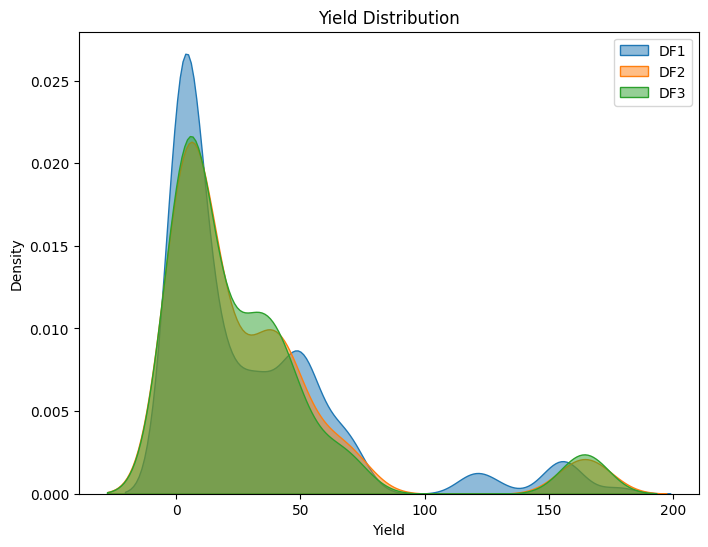

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Create the figure
plt.figure(figsize=(8, 6))

# Plot KDE distributions with filled areas (shadows)
sns.kdeplot(train_df['yield'], bw_adjust=0.5, fill=True, alpha=0.5, label='DF1')
sns.kdeplot(valid_df['yield'], bw_adjust=0.5, fill=True, alpha=0.5, label='DF2')
sns.kdeplot(test_df['yield'], bw_adjust=0.5, fill=True, alpha=0.5, label='DF3')

# Labels and title
plt.xlabel("Yield")
plt.ylabel("Density")
plt.title("Yield Distribution")
plt.legend()

# Show the plot
plt.show()

In [7]:
test_df['yield'].mean()

28.571142857142856